In [230]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from statsmodels.tsa.holtwinters import SimpleExpSmoothing, ExponentialSmoothing
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

In [231]:
df = pd.read_csv('/content/drive/MyDrive/perikanan/airnov.csv', delimiter=';' ,usecols=['Tanggal','pH'])

In [232]:
df['Tanggal'] = pd.to_datetime(df['Tanggal'])

In [233]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110 entries, 0 to 109
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   Tanggal  110 non-null    datetime64[ns]
 1   pH       110 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 1.8 KB


In [234]:
df

,Tanggal,pH
0,2023-08-10,7.8
1,2023-08-11,7.8
2,2023-08-12,7.8
3,2023-08-13,8.4
4,2023-08-14,7.8
...,...,...
105,2023-11-23,7.2
106,2023-11-24,7.2
107,2023-11-25,7.3
108,2023-11-26,7.8


In [235]:
#transfrom fata

In [236]:
df.set_index(['Tanggal',], inplace=True)

In [237]:
df.head()

,pH
Tanggal,
2023-08-10,7.8
2023-08-11,7.8
2023-08-12,7.8
2023-08-13,8.4
2023-08-14,7.8


In [238]:
df.index.min(), df.index.max()

(Timestamp('2023-08-10 00:00:00'), Timestamp('2023-11-27 00:00:00'))

In [239]:
if (df.index.max() - df.index.min() == 214):
  print ('Data is continous')

In [240]:
df.index.freq = 'D'

In [241]:
#annalisa time series

<Axes: xlabel='Tanggal'>

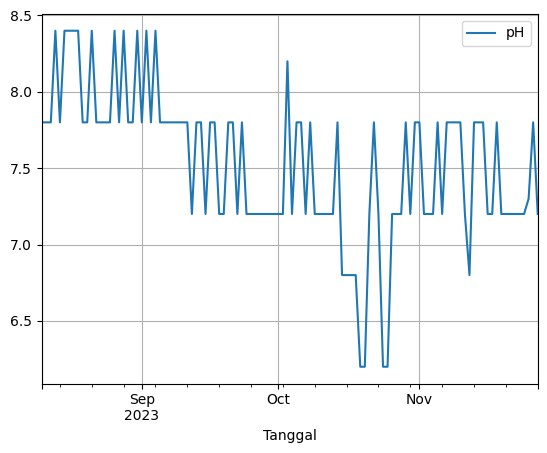

In [242]:
df.plot(grid=True)

In [243]:
train_df = df.loc[:"10-9-2023"]
test_df = df.loc["10-11-2023":]

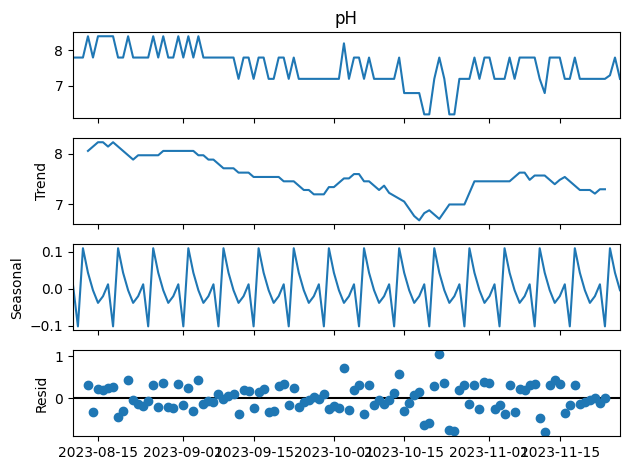

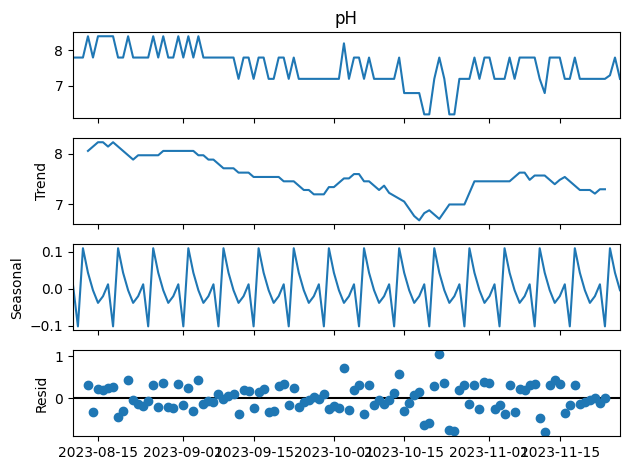

In [244]:
decompose_add = seasonal_decompose(df["pH"])
decompose_add.plot()

In [245]:
def adf_test(timeseries):
    print('Hasil testing Dickey-Fuller')
    print('--------------')
    adftest = adfuller(timeseries)
    adf_output = pd.Series(adftest[0:4], index=['Test statistic','p-value','Lags Used','Number of observation Used'])
    for key, value in adftest[4].items():
        adf_output['Critical Value (%s)' % key] = value
    print(adf_output)

adf_test(df.values)

Hasil testing Dickey-Fuller
--------------
Test statistic                 -1.902241
p-value                         0.331008
Lags Used                       4.000000
Number of observation Used    105.000000
Critical Value (1%)            -3.494220
Critical Value (5%)            -2.889485
Critical Value (10%)           -2.581676
dtype: float64


In [246]:
diff_df = df.diff()
diff_df.head()

,pH
Tanggal,
2023-08-10,NaN
2023-08-11,0.0
2023-08-12,0.0
2023-08-13,0.6
2023-08-14,-0.6


In [247]:
diff_df.dropna(inplace=True)

<Axes: xlabel='Tanggal'>

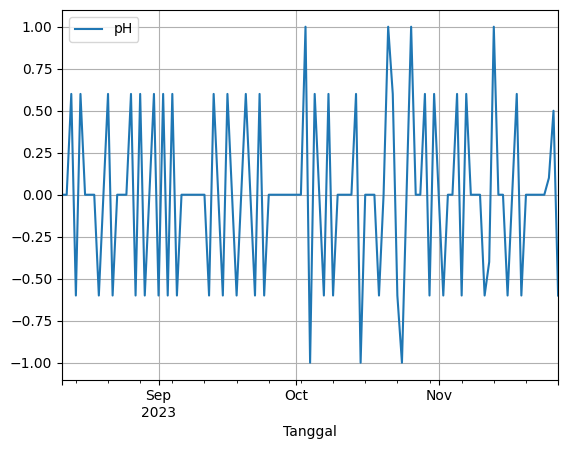

In [248]:
diff_df.plot(grid=True)

In [249]:
adf_test(diff_df)

Hasil testing Dickey-Fuller
--------------
Test statistic               -8.992219e+00
p-value                       6.843097e-15
Lags Used                     3.000000e+00
Number of observation Used    1.050000e+02
Critical Value (1%)          -3.494220e+00
Critical Value (5%)          -2.889485e+00
Critical Value (10%)         -2.581676e+00
dtype: float64


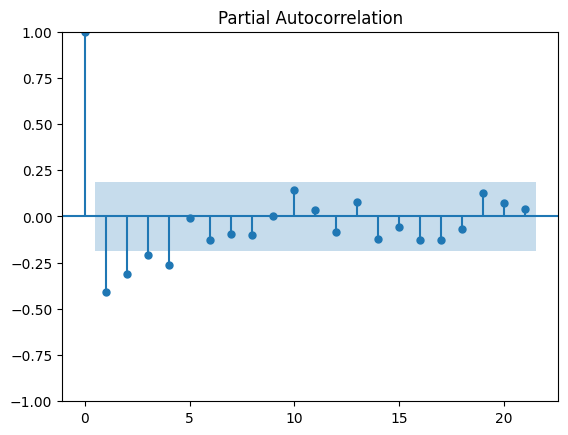

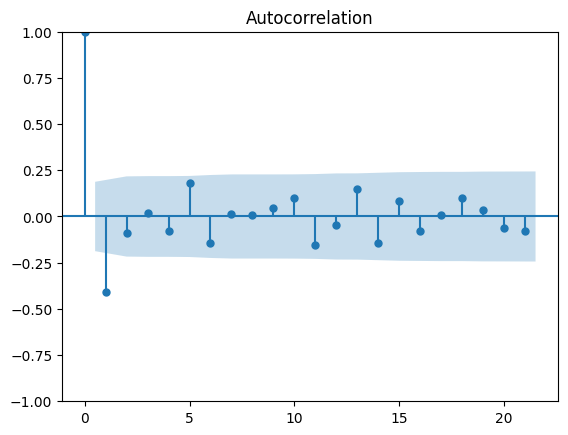

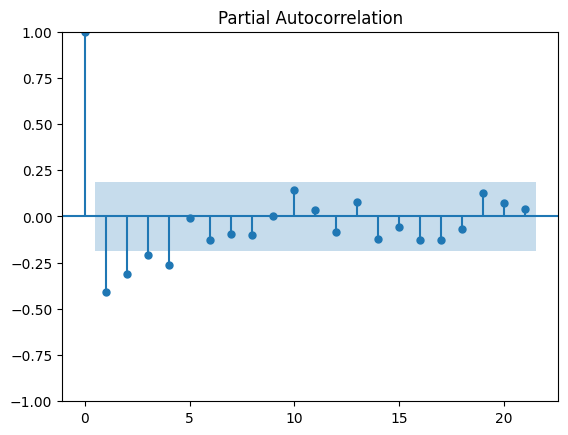

In [250]:
plot_acf(diff_df)
plot_pacf(diff_df)

In [251]:
single_exp = SimpleExpSmoothing(train_df).fit()
single_exp_train_pred = single_exp.fittedvalues
single_exp_test_pred = single_exp.forecast(len(test_df))

<Axes: xlabel='Tanggal'>

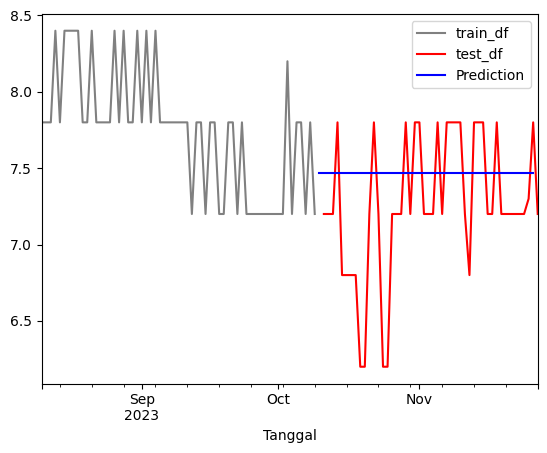

In [252]:
train_df['pH'].plot(style='', color='gray', legend=True, label='train_df')
test_df['pH'].plot(style='', color='red', legend=True, label='test_df')
single_exp_test_pred.plot(color='b', legend=True, label='Prediction')

In [253]:
print('Train RMSE: ', mean_squared_error(train_df['pH'], single_exp_train_pred)**0.5)
print('Test RMSE: ', mean_squared_error(test_df['pH'], single_exp_test_pred)**0.5)
print('Train MAPE :', mean_absolute_percentage_error(train_df['pH'], single_exp_train_pred))
print('Test MAPE :', mean_absolute_percentage_error(test_df['pH'], single_exp_test_pred))

Train RMSE:  0.3278449084356947
Test RMSE:  0.5012407136552938
Train MAPE : 0.035848662287883644
Test MAPE : 0.05908019241717304


In [254]:
# Fit the double exponential smoothing model on the training data
double_exp = ExponentialSmoothing(train_df['pH'], trend=None, initialization_method='heuristic', seasonal='add', seasonal_periods=29, damped_trend=False).fit()

# Predict on the test data with the correct number of samples
double_exp_test_pred = double_exp.forecast(len(test_df))



<Axes: xlabel='Tanggal'>

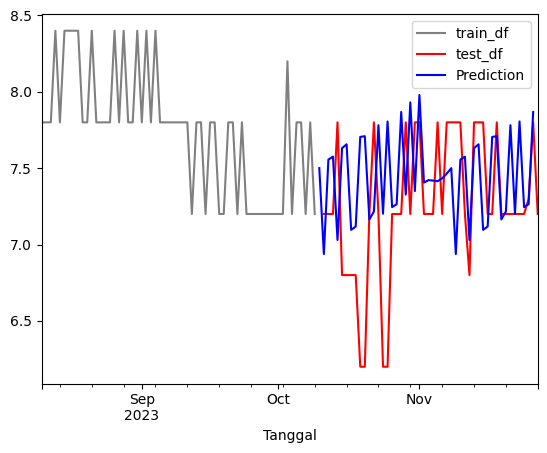

In [255]:
train_df['pH'].plot(style='', color='gray', legend=True, label='train_df')
test_df['pH'].plot(style='', color='r', legend=True, label='test_df')
double_exp_test_pred.plot(color='b', legend=True, label='Prediction')

In [256]:
print('Train RMSE: ', mean_squared_error(train_df['pH'], double_exp_train_pred)**0.5)
print('Test RMSE: ', mean_squared_error(test_df['pH'], double_exp_test_pred)**0.5)
print('Train MAPE :', mean_absolute_percentage_error(train_df['pH'], double_exp_train_pred))
print('Test MAPE :', mean_absolute_percentage_error(test_df['pH'], double_exp_test_pred))

Train RMSE:  0.3157360038254743
Test RMSE:  0.5564396956047268
Train MAPE : 0.028761305264374842
Test MAPE : 0.06003619045581452


In [257]:
# Membuat objek ARIMA dengan parameter order=(35,1,15)
ar = ARIMA(train_df['pH'], order=(35,1,15))

# Fitting model pada data latihan
ar_fit = ar.fit()

# Membuat prediksi pada data latihan
ar_train_pred = ar_fit.fittedvalues

# Membuat prediksi pada data uji dengan jumlah sampel yang sesuai
ar_test_pred = ar_fit.forecast(steps=len(test_df))

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<Axes: xlabel='Tanggal'>

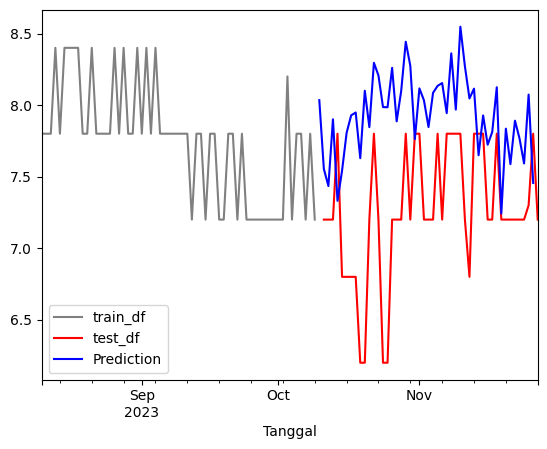

In [258]:
train_df['pH'].plot(style='', color='gray', legend=True, label='train_df')
test_df['pH'].plot(style='', color='r', legend=True, label='test_df')
ar_test_pred.plot(color='b', legend=True, label='Prediction')


In [259]:
print('Train RMSE: ', mean_squared_error(train_df['pH'], ar_train_pred)**0.5)
print('Test RMSE: ', mean_squared_error(test_df['pH'], ar_test_pred)**0.5)
print('Train MAPE :', mean_absolute_percentage_error(train_df['pH'], ar_train_pred))
print('Test MAPE :', mean_absolute_percentage_error(test_df['pH'], ar_test_pred))

Train RMSE:  1.0257396482465209
Test RMSE:  0.8315889333247555
Train MAPE : 0.03781714211976283
Test MAPE : 0.0965572400985203


In [260]:
comparision_df = pd.DataFrame(data=[
    ['Singell Exp Smoothing', 0.5012, 0.0590],
    ['double Exp Smoothing',  0.5564, 0.0600],
    ['ARIMA', 0.8315,0.0965]
    ],
    columns=['model','RMSE', 'MAPE'])
comparision_df.set_index('model', inplace=True)

In [261]:
comparision_df.sort_values(by='RMSE')

,RMSE,MAPE
model,,
Singell Exp Smoothing,0.5012,0.0590
double Exp Smoothing,0.5564,0.0600
ARIMA,0.8315,0.0965


In [262]:
double_exp = ExponentialSmoothing(df['pH'], trend=None, initialization_method='heuristic', seasonal='add', seasonal_periods=29, damped_trend=False).fit()
double_exp_pred = double_exp.forecast(len(df))

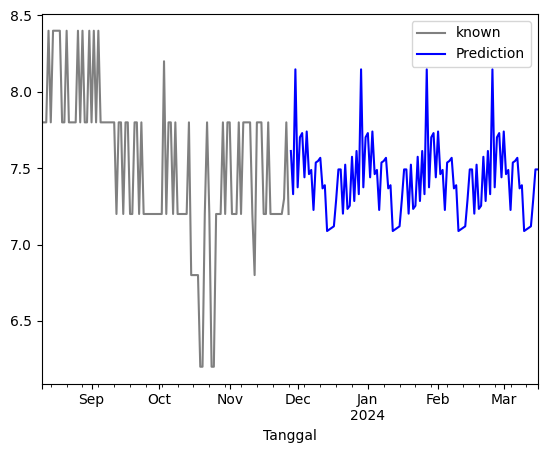

In [263]:
df['pH'].plot(style='', color='gray', legend=True, label='known')
double_exp_pred.plot(color='b', legend=True, label='Prediction')
plt.show()

In [264]:
import pickle

In [265]:
pickle.dump(double_exp, open('prediksi_ph_kedepan.sav','wb'))